In [1]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob
from tensorflow.keras import backend as K
import gc

from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

In [2]:
x = './data/train/malignant'
y  = './data/train/benign'

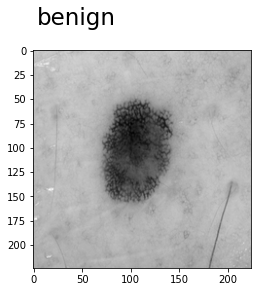

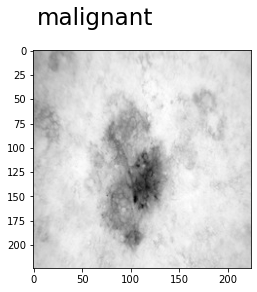

In [3]:
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt


DATADIR = "./data/train"

CATEGORIES = ["benign","malignant"]

for category in CATEGORIES: 
    path = os.path.join(DATADIR,category) 
    for img in os.listdir(path):  
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  
        plt.imshow(img_array, cmap='gray')
        plt.text(3.5, 0.9, category+"\n", fontsize = 23)
        plt.show() 

        break 

In [4]:
SIZE=224
base_model = keras.applications.resnet50.ResNet50(input_shape=(SIZE,SIZE,3),include_top=False,weights='imagenet')

In [5]:
base_model.summary();

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [6]:
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [7]:
from tensorflow.keras import regularizers

inputs = keras.Input(shape=(SIZE,SIZE,3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.003))(x)
x = layers.Dropout(0.35)(x)
x = layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.003))(x)
x = layers.Dropout(0.35)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

In [8]:
model = keras.Model(inputs, outputs)
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)              

In [9]:
diretorio = './data/train/'

In [10]:
image_size = (SIZE, SIZE)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    diretorio,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    diretorio,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 2637 files belonging to 2 classes.
Using 2110 files for training.
Found 2637 files belonging to 2 classes.
Using 527 files for validation.


In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [12]:
epochs = 30
history = model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/30
66/66 [==============================] - 111s 2s/step - loss: 1.2981 - accuracy: 0.7569 - val_loss: 0.9432 - val_accuracy: 0.8406
Epoch 2/30
66/66 [==============================] - 109s 2s/step - loss: 0.8957 - accuracy: 0.8308 - val_loss: 0.7539 - val_accuracy: 0.8501
Epoch 3/30
66/66 [==============================] - 107s 2s/step - loss: 0.7240 - accuracy: 0.8460 - val_loss: 0.6387 - val_accuracy: 0.8786
Epoch 4/30
66/66 [==============================] - 106s 2s/step - loss: 0.6116 - accuracy: 0.8682 - val_loss: 0.5715 - val_accuracy: 0.8634
Epoch 5/30
66/66 [==============================] - 105s 2s/step - loss: 0.5472 - accuracy: 0.8678 - val_loss: 0.5221 - val_accuracy: 0.8615
Epoch 6/30
66/66 [==============================] - 106s 2s/step - loss: 0.5076 - accuracy: 0.8768 - val_loss: 0.4954 - val_accuracy: 0.8786
Epoch 7/30
66/66 [==============================] - 107s 2s/step - loss: 0.4673 - accuracy: 0.8829 - val_loss: 0.4678 - val_accuracy: 0.8653
Epoch 8/30
66

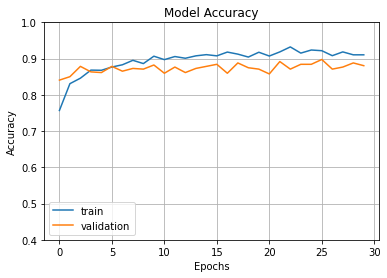

In [13]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

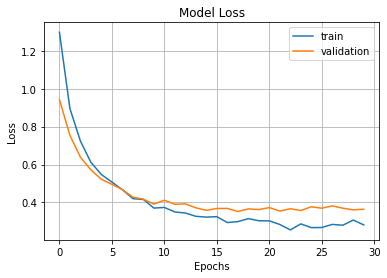

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [15]:
import cv2
#inp = r"/content/drive/MyDrive/code/data/test/melanoma/ISIC_0014766.jpg"
#inp = "../../code/data/train/melanoma/ISIC_0000029.jpg"
inp = r"./test/benign/1074.jpg"


image=cv2.imread(inp)
image_resized= cv2.resize(image, (SIZE,SIZE))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)

(1, 224, 224, 3)


In [16]:
CATEGORIES = ["BENIGN","MALIGNANT"]
pred=model.predict(image)
print(pred)

[[0.01032323]]


In [17]:
def find_class(result):
    if result >= 0.5:
        return 1
    else:
        return 0

find_class(pred[0])


0

In [18]:
output_class=CATEGORIES[find_class(pred[0])]
print("The predicted class is", output_class)

The predicted class is BENIGN


In [19]:
from tensorflow.keras.models import load_model


model.save('model_RESNET.h5')

In [20]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model=load_model('model_vgg19.h5')